In [26]:
import pandas as pd
import yfinance as yf

ticker = "SPY"
data = yf.download(ticker, start="2018-01-01")


data.columns = [col[0] for col in data.columns]

data.dropna(inplace=True)

print("Downloaded data shape:", data.shape)
print("\nFirst 5 rows with simplified column names:")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Downloaded data shape: (1933, 5)

First 5 rows with simplified column names:
                 Close        High         Low        Open    Volume
Date                                                                
2018-01-02  238.568710  238.604223  237.352659  237.743220  86655700
2018-01-03  240.077698  240.228607  238.737365  238.737365  90070400
2018-01-04  241.089584  241.577798  240.139839  240.725679  80636400
2018-01-05  242.696228  242.820482  241.391409  241.888480  83524000
2018-01-08  243.140076  243.299843  242.305700  242.598606  57319200


In [38]:
import numpy as np


data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['Volatility_21d'] = data['Log_Returns'].rolling(window=21).std() * np.sqrt(252)


data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()


data['Momentum_50'] = (data['Close'] / data['Close'].rolling(window=50).mean()) - 1
data['Momentum_200'] = (data['Close'] / data['Close'].rolling(window=200).mean()) - 1


delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
data['RSI_14'] = 100 - (100 / (1 + RS))


data['Lag_Volatility_1'] = data['Volatility_21d'].shift(1)
data['Lag_Volatility_5'] = data['Volatility_21d'].shift(5)


data.dropna(inplace=True)

print("Data shape after feature engineering:", data.shape)
print("\nFirst 5 rows with new features:")
print(data.head())

Data shape after feature engineering: (1535, 14)

First 5 rows with new features:
                 Close        High         Low        Open     Volume  \
Date                                                                    
2019-08-02  267.131165  268.500506  265.560985  268.254035  116749700   
2019-08-05  259.097748  263.105341  257.180664  262.995798  178745400   
2019-08-06  262.730988  262.950101  259.517609  261.005632  120711700   
2019-08-07  262.886230  263.662196  257.472773  259.627190  140572300   
2019-08-08  268.044128  268.044128  263.835697  264.392550   87713900   

            Log_Returns  Volatility_21d      SMA_50     SMA_200  Momentum_50  \
Date                                                                           
2019-08-02    -0.007558        0.084925  266.462087  252.510646     0.002511   
2019-08-05    -0.030534        0.132995  266.517693  252.545399    -0.027840   
2019-08-06     0.013925        0.143857  266.634335  252.598094    -0.014639   
2019-0

In [40]:
from sklearn.model_selection import train_test_split


features = data.drop(columns=['Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns', 'Volatility_21d'])
target = data['Volatility_21d']


split_index = int(0.8 * len(features))
X_train = features.iloc[:split_index]
X_test = features.iloc[split_index:]
y_train = target.iloc[:split_index]
y_test = target.iloc[split_index:]


print("Training data shape (features):", X_train.shape)
print("Testing data shape (features):", X_test.shape)
print("Training data shape (target):", y_train.shape)
print("Testing data shape (target):", y_test.shape)

Training data shape (features): (1228, 7)
Testing data shape (features): (307, 7)
Training data shape (target): (1228,)
Testing data shape (target): (307,)


In [44]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

#XGBoost Regressor model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Make predictions 
predictions = model.predict(X_test)

# Evaluate  performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 0.0013
R-squared (R2): 0.8736


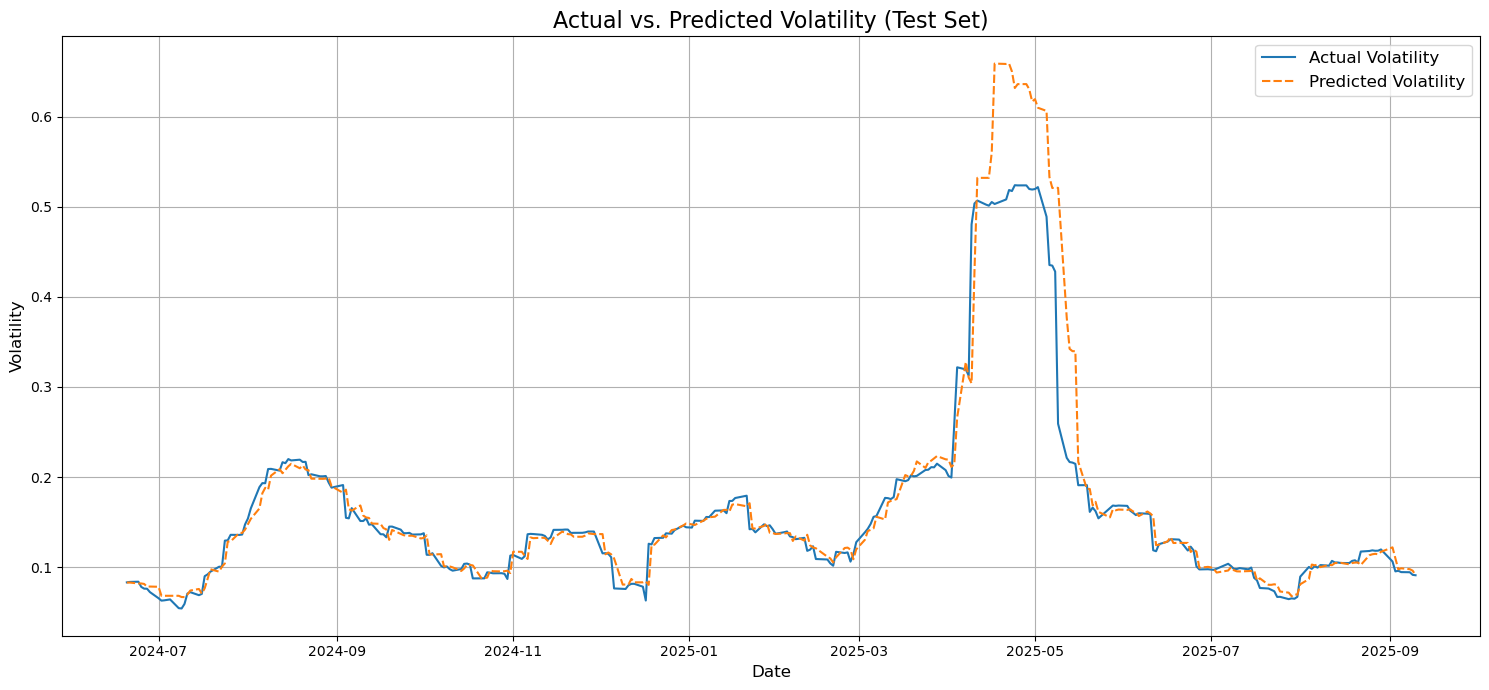

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns


results = pd.DataFrame({
    'Actual Volatility': y_test,
    'Predicted Volatility': predictions
})


plt.figure(figsize=(15, 7))
sns.lineplot(data=results)


plt.title('Actual vs. Predicted Volatility (Test Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()


plt.show()

In [48]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1
)


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print(f"Best R2 Score (from cross-validation): {best_score:.4f}")


final_model = xgb.XGBRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)


final_predictions = final_model.predict(X_test)
final_r2 = r2_score(y_test, final_predictions)

print(f"\nFinal R2 Score on Test Set: {final_r2:.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best R2 Score (from cross-validation): 0.7973

Final R2 Score on Test Set: 0.9471


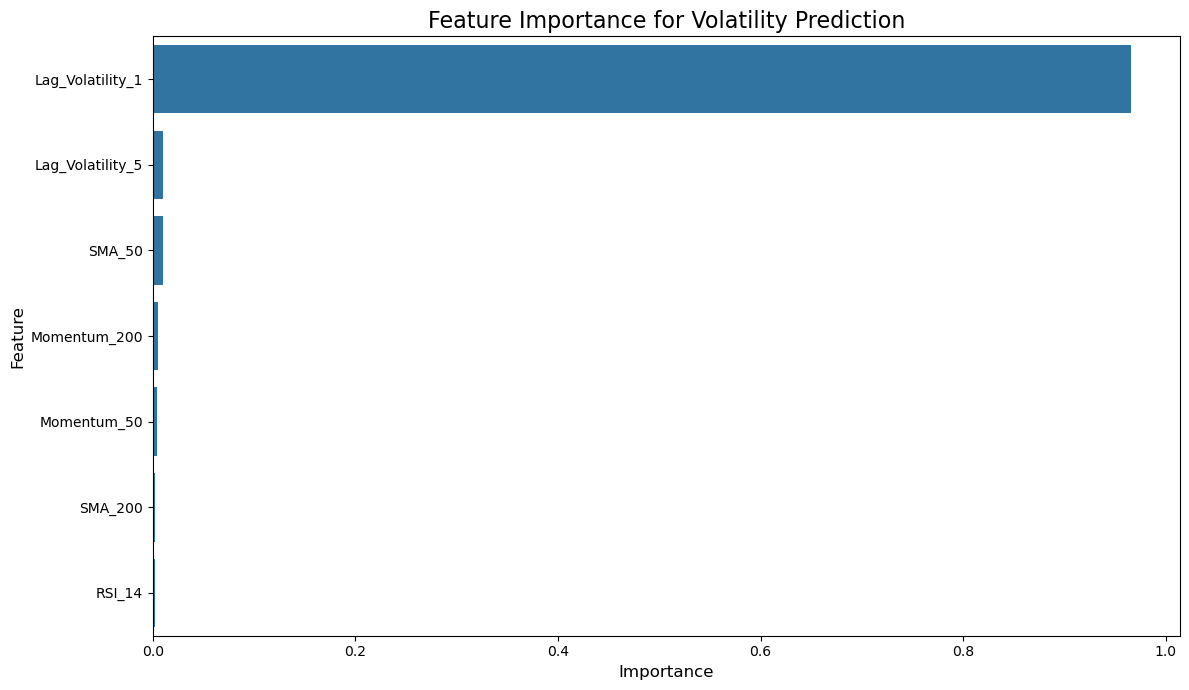

Top 5 most important features:
            Feature  Importance
5  Lag_Volatility_1    0.965864
6  Lag_Volatility_5    0.010269
0            SMA_50    0.009937
3      Momentum_200    0.004945
2       Momentum_50    0.003984


In [50]:

feature_importances = final_model.feature_importances_


feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Volatility Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("Top 5 most important features:")
print(importance_df.head())

In [52]:
from sklearn.model_selection import TimeSeriesSplit


X_full = features
y_full = target


n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

r2_scores = []

for train_index, test_index in tscv.split(X_full):

    X_train_ts, X_test_ts = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train_ts, y_test_ts = y_full.iloc[train_index], y_full.iloc[test_index]


    model_ts = xgb.XGBRegressor(**best_params, random_state=42)
    model_ts.fit(X_train_ts, y_train_ts)

    predictions_ts = model_ts.predict(X_test_ts)
    r2 = r2_score(y_test_ts, predictions_ts)
    r2_scores.append(r2)

    print(f"R2 Score for split {len(r2_scores)}: {r2:.4f}")

print(f"\nAverage R2 Score from Backtesting: {np.mean(r2_scores):.4f}")

R2 Score for split 1: 0.9373
R2 Score for split 2: 0.9176
R2 Score for split 3: 0.9693
R2 Score for split 4: 0.9642
R2 Score for split 5: 0.9578

Average R2 Score from Backtesting: 0.9492


In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import numpy as np


class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        df = X.copy()


        df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['Volatility_21d'] = df['Log_Returns'].rolling(window=21).std() * np.sqrt(252)


        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['SMA_200'] = df['Close'].rolling(window=200).mean()
        df['Momentum_50'] = (df['Close'] / df['Close'].rolling(window=50).mean()) - 1
        df['Momentum_200'] = (df['Close'] / df['Close'].rolling(window=200).mean()) - 1

        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        RS = gain / loss
        df['RSI_14'] = 100 - (100 / (1 + RS))


        df['Lag_Volatility_1'] = df['Volatility_21d'].shift(1)
        df['Lag_Volatility_5'] = df['Volatility_21d'].shift(5)


        df.dropna(inplace=True)
        

        features = df.drop(columns=['Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns', 'Volatility_21d'])
        return features


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


full_pipeline = make_pipeline(
    FeatureEngineer(),
    xgb.XGBRegressor(**best_params, random_state=42)
)

print(full_pipeline)

Pipeline(steps=[('featureengineer', FeatureEngineer()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                          

In [56]:
import joblib


joblib.dump(final_model, 'volatility_model.joblib')

print("Model saved as volatility_model.joblib")


loaded_model = joblib.load('volatility_model.joblib')


loaded_predictions = loaded_model.predict(X_test)


are_identical = np.allclose(loaded_predictions, final_predictions)

print(f"\nAre the loaded model's predictions identical to the original? {are_identical}")

Model saved as volatility_model.joblib

Are the loaded model's predictions identical to the original? True


In [58]:
import pandas as pd
import yfinance as yf
import joblib
import numpy as np


loaded_model = joblib.load('volatility_model.joblib')


end_date = pd.to_datetime('today')
start_date = end_date - pd.Timedelta(days=300)


new_data = yf.download("SPY", start=start_date, end=end_date)
new_data.columns = [col[0] for col in new_data.columns]
new_data.dropna(inplace=True)


new_data['Log_Returns'] = np.log(new_data['Close'] / new_data['Close'].shift(1))
new_data['Volatility_21d'] = new_data['Log_Returns'].rolling(window=21).std() * np.sqrt(252)
new_data['SMA_50'] = new_data['Close'].rolling(window=50).mean()
new_data['SMA_200'] = new_data['Close'].rolling(window=200).mean()
new_data['Momentum_50'] = (new_data['Close'] / new_data['Close'].rolling(window=50).mean()) - 1
new_data['Momentum_200'] = (new_data['Close'] / new_data['Close'].rolling(window=200).mean()) - 1
delta = new_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
new_data['RSI_14'] = 100 - (100 / (1 + RS))
new_data['Lag_Volatility_1'] = new_data['Volatility_21d'].shift(1)
new_data['Lag_Volatility_5'] = new_data['Volatility_21d'].shift(5)


new_data.dropna(inplace=True)


latest_data = new_data.iloc[-1].drop(['Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns', 'Volatility_21d'])


latest_features = pd.DataFrame(latest_data).transpose()


prediction = loaded_model.predict(latest_features)

print(f"Predicted Volatility for the next day: {prediction[0]:.4f}")

[*********************100%***********************]  1 of 1 completed

Predicted Volatility for the next day: 0.0905


In [60]:
import pandas as pd
import yfinance as yf
import joblib
import numpy as np

loaded_model = joblib.load('volatility_model.joblib')

def predict_volatility(ticker):
    """
    Downloads data for a given ticker, engineers features,
    and predicts its future volatility.
    """
    print(f"Fetching data for {ticker}...")
    

    end_date = pd.to_datetime('today')
    start_date = end_date - pd.Timedelta(days=300)
    new_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    

    if new_data.empty:
        print(f"Could not download data for {ticker}. Skipping.")
        return None
    

    new_data.columns = [col[0] for col in new_data.columns]
    new_data.dropna(inplace=True)


    new_data['Log_Returns'] = np.log(new_data['Close'] / new_data['Close'].shift(1))
    new_data['Volatility_21d'] = new_data['Log_Returns'].rolling(window=21).std() * np.sqrt(252)
    new_data['SMA_50'] = new_data['Close'].rolling(window=50).mean()
    new_data['SMA_200'] = new_data['Close'].rolling(window=200).mean()
    new_data['Momentum_50'] = (new_data['Close'] / new_data['Close'].rolling(window=50).mean()) - 1
    new_data['Momentum_200'] = (new_data['Close'] / new_data['Close'].rolling(window=200).mean()) - 1
    delta = new_data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    new_data['RSI_14'] = 100 - (100 / (1 + RS))
    new_data['Lag_Volatility_1'] = new_data['Volatility_21d'].shift(1)
    new_data['Lag_Volatility_5'] = new_data['Volatility_21d'].shift(5)
    
    new_data.dropna(inplace=True)


    latest_data = new_data.iloc[-1].drop(['Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns', 'Volatility_21d'])
    

    latest_features = pd.DataFrame(latest_data).transpose()

    prediction = loaded_model.predict(latest_features)
    return prediction[0]


tickers_to_predict = ['AAPL', 'TSLA', 'VTI']

for ticker in tickers_to_predict:
    predicted_volatility = predict_volatility(ticker)
    if predicted_volatility is not None:
        print(f"Predicted Volatility for {ticker}: {predicted_volatility:.4f}")

Fetching data for AAPL...
Predicted Volatility for AAPL: 0.1966
Fetching data for TSLA...
Predicted Volatility for TSLA: 0.3366
Fetching data for VTI...
Predicted Volatility for VTI: 0.0984


In [2]:
import pandas as pd
import yfinance as yf
import joblib
import numpy as np


loaded_model = joblib.load('volatility_model.joblib')


end_date = pd.to_datetime('today').normalize() - pd.Timedelta(days=1)
start_date = end_date - pd.Timedelta(days=300)


historical_data = yf.download("NVDA", start=start_date, end=end_date, progress=False)
historical_data.columns = [col[0] for col in historical_data.columns]
historical_data.dropna(inplace=True)


historical_data['Log_Returns'] = np.log(historical_data['Close'] / historical_data['Close'].shift(1))
historical_data['Volatility_21d'] = historical_data['Log_Returns'].rolling(window=21).std() * np.sqrt(252)
historical_data['SMA_50'] = historical_data['Close'].rolling(window=50).mean()
historical_data['SMA_200'] = historical_data['Close'].rolling(window=200).mean()
historical_data['Momentum_50'] = (historical_data['Close'] / historical_data['Close'].rolling(window=50).mean()) - 1
historical_data['Momentum_200'] = (historical_data['Close'] / historical_data['Close'].rolling(window=200).mean()) - 1
delta = historical_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
historical_data['RSI_14'] = 100 - (100 / (1 + RS))
historical_data['Lag_Volatility_1'] = historical_data['Volatility_21d'].shift(1)
historical_data['Lag_Volatility_5'] = historical_data['Volatility_21d'].shift(5)

historical_data.dropna(inplace=True)


features = historical_data.drop(columns=['Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns', 'Volatility_21d'])
target = historical_data['Volatility_21d']


features_for_prediction = features.iloc[-1]
actual_volatility = target.iloc[-1]

features_for_prediction_df = pd.DataFrame(features_for_prediction).transpose()


predicted_volatility = loaded_model.predict(features_for_prediction_df)

print(f"Predicted Volatility for Yesterday: {predicted_volatility[0]:.4f}")
print(f"Actual Volatility for Yesterday:    {actual_volatility:.4f}")


error = abs(predicted_volatility[0] - actual_volatility) / actual_volatility * 100
print(f"Prediction Error: {error:.2f}%")

YF.download() has changed argument auto_adjust default to True
Predicted Volatility for Yesterday: 0.2261
Actual Volatility for Yesterday:    0.2381
Prediction Error: 5.06%
